本题采用参数时变的SIR模型。
选用2022年4月13日至4月28日，共16天数据，进行建模分析。
数据存储采用csv格式存储，并在python中使用pandas库进行读取，下面一段代码展示的即为读取数据并求出患者数（i）和被移除者数量（r）。

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('data1.csv')
data.loc[:,'r'] = data["累计治愈"] + data["累计死亡"]
data.loc[:,'i'] = data["累计确诊"] - data["r"]
data.head(10)

,日期,累计治愈,累计死亡,累计确诊,r,i
0,1,143922,4638,171382,148560,22822
1,2,145352,4638,174868,149990,24878
2,3,148170,4638,178764,152808,25956
3,4,149770,4638,182293,154408,27885
4,5,151407,4641,185035,156048,28987
5,6,153319,4648,188351,157967,30384
6,7,155684,4655,191112,160339,30773
7,8,157869,4663,193953,162532,31421
8,9,160599,4674,196086,165273,30813
9,10,163726,4686,199074,168412,30662


下面画出患者数和被移除数随时间变化的散点图。

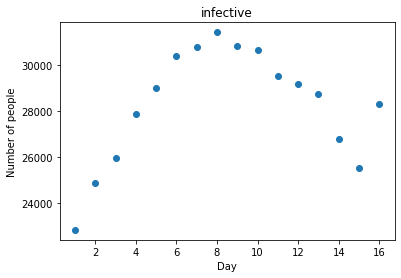

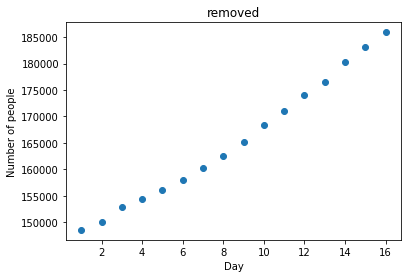

In [2]:
import matplotlib.pyplot as plt
plt.scatter(data['日期'], data['i'])
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.title('infective')
plt.show()

plt.scatter(data['日期'], data['r'])
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.title('removed')
plt.show()

分别求出i(t)和r(t)，并清除空行(即NaN)。

之后在分别计算感染率(lam)和移除率(u)。

In [3]:
#求i，r差分
data['new_r']=data['r'].diff(1)
data['new_i']=data['i'].diff(1)

#clear NaN
data.drop(0,inplace=True) 

#get u,lamba
data['u'] = data['new_r'] / data['i']
data['lam'] = (data['new_r']+data['new_i']) / data['i']
data.head(10)

,日期,累计治愈,累计死亡,累计确诊,r,i,new_r,new_i,u,lam
1,2,145352,4638,174868,149990,24878,1430.0,2056.0,0.057481,0.140124
2,3,148170,4638,178764,152808,25956,2818.0,1078.0,0.108568,0.150100
3,4,149770,4638,182293,154408,27885,1600.0,1929.0,0.057379,0.126555
4,5,151407,4641,185035,156048,28987,1640.0,1102.0,0.056577,0.094594
5,6,153319,4648,188351,157967,30384,1919.0,1397.0,0.063158,0.109136
6,7,155684,4655,191112,160339,30773,2372.0,389.0,0.077081,0.089722
7,8,157869,4663,193953,162532,31421,2193.0,648.0,0.069794,0.090417
8,9,160599,4674,196086,165273,30813,2741.0,-608.0,0.088956,0.069224
9,10,163726,4686,199074,168412,30662,3139.0,-151.0,0.102374,0.097450
10,11,166398,4725,200654,171123,29531,2711.0,-1131.0,0.091802,0.053503


分别画出感染率和被移除率随着时间变化的曲线，如下图：

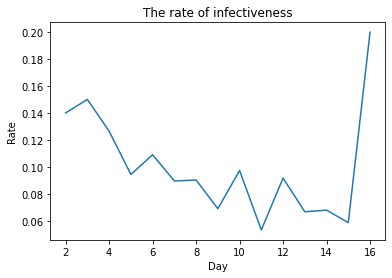

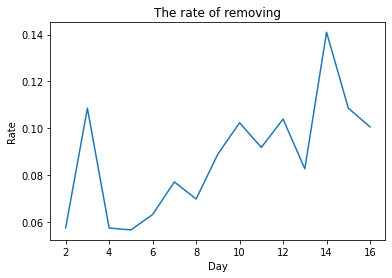

In [4]:
#painting u and lam
#plt.scatter(data['日期'], data['lam'])
plt.plot(data['日期'], data['lam'])
plt.xlabel('Day')
plt.ylabel('Rate')
plt.title('The rate of infectiveness')
plt.show()

#plt.scatter(data['日期'], data['u'])
plt.plot(data['日期'], data['u'])
plt.xlabel('Day')
plt.ylabel('Rate')
plt.title('The rate of removing')
plt.show()

#拟合数据

假设感染率和移除率都是自然常数e的指数函数，利用scipy库的curve_fit函数对曲线进行拟合，并画出拟合后的曲线。

0.12933937983584243 -0.029162252886947362


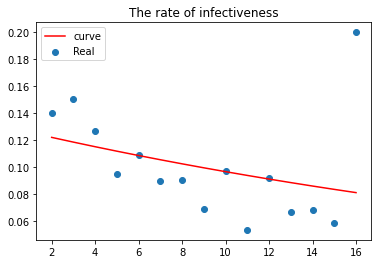

0.05891135829582002 0.04191867171520118


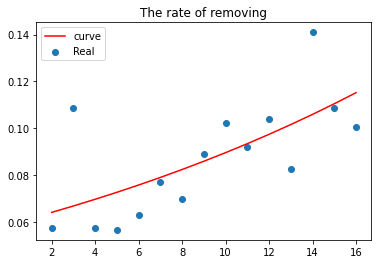

In [5]:
import math
from scipy import optimize as op
def f_1(x, A, B):
    return A * np.exp(B * x)
x = np.array(data['日期'].tolist())
y1 = np.array(data['lam'].tolist())

A1, B1 = op.curve_fit(f_1,x,y1)[0]
print(A1,B1)
plt.scatter(x,y1,marker='o',label='Real')
yf1 = f_1(x,A1,B1)
plt.plot(x, yf1,color='red',label='curve')
plt.title('The rate of infectiveness')
plt.legend() # 显示label
plt.show()

y2 = np.array(data['u'].tolist())
A2, B2 = op.curve_fit(f_1,x,y2)[0]
print(A2,B2)
plt.scatter(x,y2,marker='o',label='Real')
yf2 = f_1(x,A2,B2)
plt.plot(x, yf2,color='red',label='curve')
plt.legend() # 显示label
plt.title('The rate of removing')
plt.show()

算出拟合后的函数后，代入起始的微分方程中，使用scipy库的odeint函数求出常微分方程数值解，并画出模型求出的曲线。

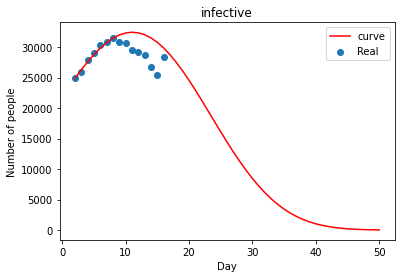

In [6]:
#常微分方程数值解
from scipy.integrate import odeint
i = np.array(data['i'].tolist())
r = np.array(data['r'].tolist())
initial = r[0]
initial1 = i[0]
def sol_i(x,y):
    return (f_1(x,A1,B1) - f_1(x,A2,B2)) * y
x = np.linspace(2,50,49)
n_i = odeint(sol_i,initial1,x,tfirst=True)

plt.scatter(x[:15],i,marker='o',label='Real')
plt.plot(x,n_i,color='red',label='curve')
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.title('infective')
plt.legend() # 显示label
plt.show()

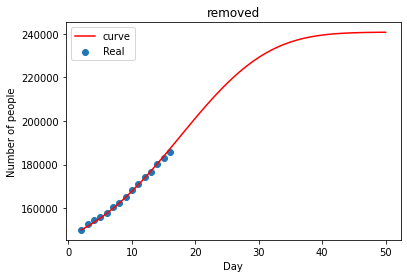

In [7]:
#常微分方程数值解

def get_i(x):
    return n_i[int(x)-2]
def sol_r(x,y):
    return f_1(x,A2,B2) * get_i(x)
n_r = odeint(sol_r,initial,x,tfirst=True)

plt.scatter(x[:15],r,marker='o',label='Real')
plt.plot(x,n_r,color='red',label='curve')
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.title('removed')
plt.legend() # 显示label
plt.show()

从上图可以看出，感染人数的拟合曲线以及移除人数大致与起始数据一致，且大约在40天后，即5月23日感染人数将降为0。